# OpenScope's Dendritic Coupling Dataset

### Environment Setup
⚠️**Note: If running on a new environment, run this cell once and then restart the kernel**⚠️

In [14]:
try:
    from dandi_utils import dandi_download_open
except:
    !git clone https://github.com/AllenInstitute/openscope_databook.git
    %cd openscope_databook
    %pip install -e .

In [15]:
import os

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from scipy import interpolate
from scipy.stats import ttest_ind

### Downloading Ophys File

In [16]:
dandiset_id = "000336"
dandi_filepath = "sub-621602/sub-621602_ses-1194809891-acq-1194973904_ophys.nwb"
download_loc = "."
dandi_api_key = os.environ["DANDI_API_KEY"]

In [17]:
# This can sometimes take a while depending on the size of the file
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

PATH                                               SIZE     DONE            DONE% CHECKSUM STATUS          MESSAGE
sub-621602_ses-1194809891-acq-1194973904_ophys.nwb 172.0 MB 172.0 MB         100%    ok    done                   
Summary:                                           172.0 MB 172.0 MB                       1 done                 
                                                            100.00%                                               
Downloaded file to ./sub-621602_ses-1194809891-acq-1194973904_ophys.nwb
Opening file


c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-common' version 1.5.0 because version 1.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'core' version 2.3.0 because version 2.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."
c:\Users\carter.peene\AppData\Local\Programs\Python\Python39\lib\site-packages\hdmf\spec\namespace.py:531: UserWarning: Ignoring cached namespace 'hdmf-experimental' version 0.1.0 because version 0.5.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


In [18]:
nwb.subject

subject pynwb.file.Subject at 0x2457023745856
Fields:
  age: P167.0D
  description: external: 621602 donor_id: 1168633075 specimen_id: [(1168633086,)]
  genotype: Rbp4-Cre_KL100/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt
  sex: F
  species: Mus musculus
  subject_id: 621602

In [19]:
nwb.lab_meta_data

{'metadata': metadata abc.OphysMetadata at 0x2457023744032
 Fields:
   experiment_container_id: 0
   field_of_view_height: 512
   field_of_view_width: 512
   imaging_depth: 343
   imaging_plane_group: 0
   imaging_plane_group_count: 4
   ophys_experiment_id: 1194973904
   ophys_session_id: 1194809891}

In [20]:
nwb.imaging_planes

{'imaging_plane_1': imaging_plane_1 pynwb.ophys.ImagingPlane at 0x2457023442512
 Fields:
   conversion: 1.0
   description: (512, 512) field of view in VISp at depth 343 um
   device: MESO.2 pynwb.device.Device at 0x2457023440976
 Fields:
   description: Allen Brain Observatory - Mesoscope 2P Rig
 
   excitation_lambda: 910.0
   imaging_rate: 11.0
   indicator: GCaMP6f
   location: VISp
   optical_channel: (
     channel_1 <class 'pynwb.ophys.OpticalChannel'>
   )
   unit: meters}

### Selecting Stimulus Times

In [21]:
nwb.intervals.keys()

dict_keys(['fixed_gabors_presentations', 'gratings_presentations', 'movie_flower_fwd_presentations', 'movie_flower_fwd_rev_presentations', 'movie_flower_rev_fwd_presentations', 'movie_flower_rev_presentations', 'movie_touch_of_evil_fwd_presentations', 'movie_touch_of_evil_fwd_rev_presentations', 'movie_touch_of_evil_rev_fwd_presentations', 'movie_touch_of_evil_rev_presentations', 'movie_worms_fwd_presentations', 'movie_worms_fwd_rev_presentations', 'movie_worms_rev_fwd_presentations', 'movie_worms_rev_presentations', 'rotate_gabors_presentations', 'spontaneous_presentations'])

In [22]:
stim_table = nwb.intervals["movie_flower_fwd_rev_presentations"]
print(stim_table.colnames)
stim_table[:10]

('start_time', 'stop_time', 'stimulus_name', 'stimulus_block', 'units', 'stimulus_index', 'frame', 'color', 'contrast', 'opacity', 'ori', 'size', 'tags', 'timeseries')


,start_time,stop_time,stimulus_name,stimulus_block,units,stimulus_index,frame,color,contrast,opacity,ori,size,tags,timeseries
id,,,,,,,,,,,,,,
0,1981.637550,1981.670910,movie_flower_fwd_rev,13.0,pix,6.0,0.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117820, 2, timestamps pynwb.base.TimeSeries ..."
1,1981.670910,1981.704271,movie_flower_fwd_rev,13.0,pix,6.0,1.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117822, 2, timestamps pynwb.base.TimeSeries ..."
2,1981.704271,1981.737631,movie_flower_fwd_rev,13.0,pix,6.0,2.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117824, 2, timestamps pynwb.base.TimeSeries ..."
3,1981.737631,1981.770992,movie_flower_fwd_rev,13.0,pix,6.0,3.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117826, 2, timestamps pynwb.base.TimeSeries ..."
4,1981.770992,1981.804352,movie_flower_fwd_rev,13.0,pix,6.0,4.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117828, 2, timestamps pynwb.base.TimeSeries ..."
5,1981.804352,1981.837713,movie_flower_fwd_rev,13.0,pix,6.0,5.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117830, 2, timestamps pynwb.base.TimeSeries ..."
6,1981.837713,1981.871073,movie_flower_fwd_rev,13.0,pix,6.0,6.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117832, 2, timestamps pynwb.base.TimeSeries ..."
7,1981.871073,1981.904434,movie_flower_fwd_rev,13.0,pix,6.0,7.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117834, 2, timestamps pynwb.base.TimeSeries ..."
8,1981.904434,1981.937794,movie_flower_fwd_rev,13.0,pix,6.0,8.0,"[1.0, 1.0, 1.0]",1.0,1.0,0.0,"[1920.0, 1080.0]",[stimulus_time_interval],"[(117836, 2, timestamps pynwb.base.TimeSeries ..."


In [23]:
print(np.mean(np.diff(stim_table.start_time)))
print(set(stim_table.frame))

0.4125333394659612
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 113.0, 114.0, 115.0, 116.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 132.0, 133.0, 134.0, 135.0, 136.0, 137.0, 138.0, 139.0, 140.0, 141.0, 142.0, 143.0, 144.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 153.0, 154.0, 155.0

In [24]:
# flower video reverses around frame 190
rev_stim_select = lambda row: row.frame.item() == 190
rev_stim_times = [float(stim_table[i].start_time) for i in range(len(stim_table)) if rev_stim_select(stim_table[i])]
print(len(rev_stim_times))

15


### Extracting ROI Fluorescence

In [25]:
dff = nwb.processing["ophys"]["dff"]
dff_trace = dff.roi_response_series["traces"].data
dff_timestamps = dff.roi_response_series["traces"].timestamps

# accessing the above data may look different for older nwb files, like the following
# dff_trace = dff.roi_response_series["RoiResponseSeries"].data
# dff_timestamps = dff.roi_response_series["RoiResponseSeries"].timestamps

print(dff_trace.shape)
print(dff_timestamps.shape)

(44183, 59)
(44183,)


### Generating Response Windows

In [26]:
window_start_time = -2
window_end_time = 3
interp_hz = 10

In [27]:
# generate regularly-space x values and interpolate along it
time_axis = np.arange(dff_timestamps[0], dff_timestamps[-1], step=(1/interp_hz))
interp_dff = []

# interpolate channel by channel to save RAM
for channel in range(dff_trace.shape[1]):
    f = interpolate.interp1d(dff_timestamps, dff_trace[:,channel], axis=0, kind="nearest", fill_value="extrapolate")
    interp_dff.append(f(time_axis))

interp_dff = np.array(interp_dff)

print(interp_dff.shape)

(59, 39415)


In [28]:
# validate window bounds
if window_start_time > 0:
    raise ValueError("start time must be non-positive number")
if window_end_time <= 0:
    raise ValueError("end time must be positive number")
    
# get event windows
windows = []
window_length = int((window_end_time-window_start_time) * interp_hz)

for stim_ts in rev_stim_times:
    # convert time to index
    start_idx = int( (stim_ts + window_start_time - dff_timestamps[0]) * interp_hz )
    end_idx = start_idx + window_length
 
    # bounds checking
    if start_idx < 0 or end_idx > interp_dff.shape[1]:
        continue
        
    windows.append(interp_dff[:,start_idx:end_idx])
    
if len(windows) == 0:
    raise ValueError("There are no windows for these timestamps")

windows = np.array(windows) * 100 # x100 to convert values to dF/F percentage
neuronwise_windows = np.swapaxes(windows,0,1)

print(neuronwise_windows.shape)

(59, 15, 50)


### Showing Response Windows

In [29]:
def show_dff_response(ax, dff, window_start_time, window_end_time, aspect="auto", vmin=None, vmax=None, yticklabels=[], skipticks=1, xlabel="Time (s)", ylabel="ROI", cbar=True, cbar_label=None):
    if len(dff) == 0:
        print("Input data has length 0; Nothing to display")
        return

    img = ax.imshow(dff, aspect=aspect, extent=[window_start_time, window_end_time, 0, len(dff)], vmin=vmin, vmax=vmax)
    if cbar:
        ax.colorbar(img, shrink=0.5, label=cbar_label)

    ax.plot([0,0],[0, len(dff)], ":", color="white", linewidth=1.0)

    if len(yticklabels) != 0:
        ax.set_yticks(range(len(yticklabels)))
        ax.set_yticklabels(yticklabels, fontsize=8)

        n_ticks = len(yticklabels[::skipticks])
        ax.yaxis.set_major_locator(plt.MaxNLocator(n_ticks))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

In [30]:
def show_many_responses(windows, rows, cols, window_idxs=None, title=None, subplot_title="", xlabel=None, ylabel=None, cbar_label=None, vmin=0, vmax=100):
    if window_idxs is None:
        window_idxs = range(len(windows))
    windows = windows[window_idxs]
    
    # handle case with no input data
    if len(windows) == 0:
        print("Input data has length 0; Nothing to display")
        return
    # handle cases when there aren't enough windows for number of rows
    if len(windows) < rows*cols:
        rows = (len(windows) // cols) + 1

    fig, axes = plt.subplots(rows, cols, figsize=(2*cols+2, 2*rows+2), layout="constrained")
    # handle case when there's only one row
    if len(axes.shape) == 1:
        axes = axes.reshape((1, axes.shape[0]))
    
    for i in range(rows*cols):
        ax_row = int(i // cols)
        ax_col = i % cols
        ax = axes[ax_row][ax_col]
        
        if i > len(windows)-1:
            ax.set_visible(False)
            continue

        window = windows[i]
        show_dff_response(ax, window, window_start_time, window_end_time, xlabel=xlabel, ylabel=ylabel, cbar=False, vmin=vmin, vmax=vmax)
        ax.set_title(f"{subplot_title} {window_idxs[i]}")
        if ax_row != rows-1:
            ax.get_xaxis().set_visible(False)
        if ax_col != 0:
            ax.get_yaxis().set_visible(False)

    fig.suptitle(title)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    colorbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm), ax=axes, shrink=1.5/rows, label=cbar_label)

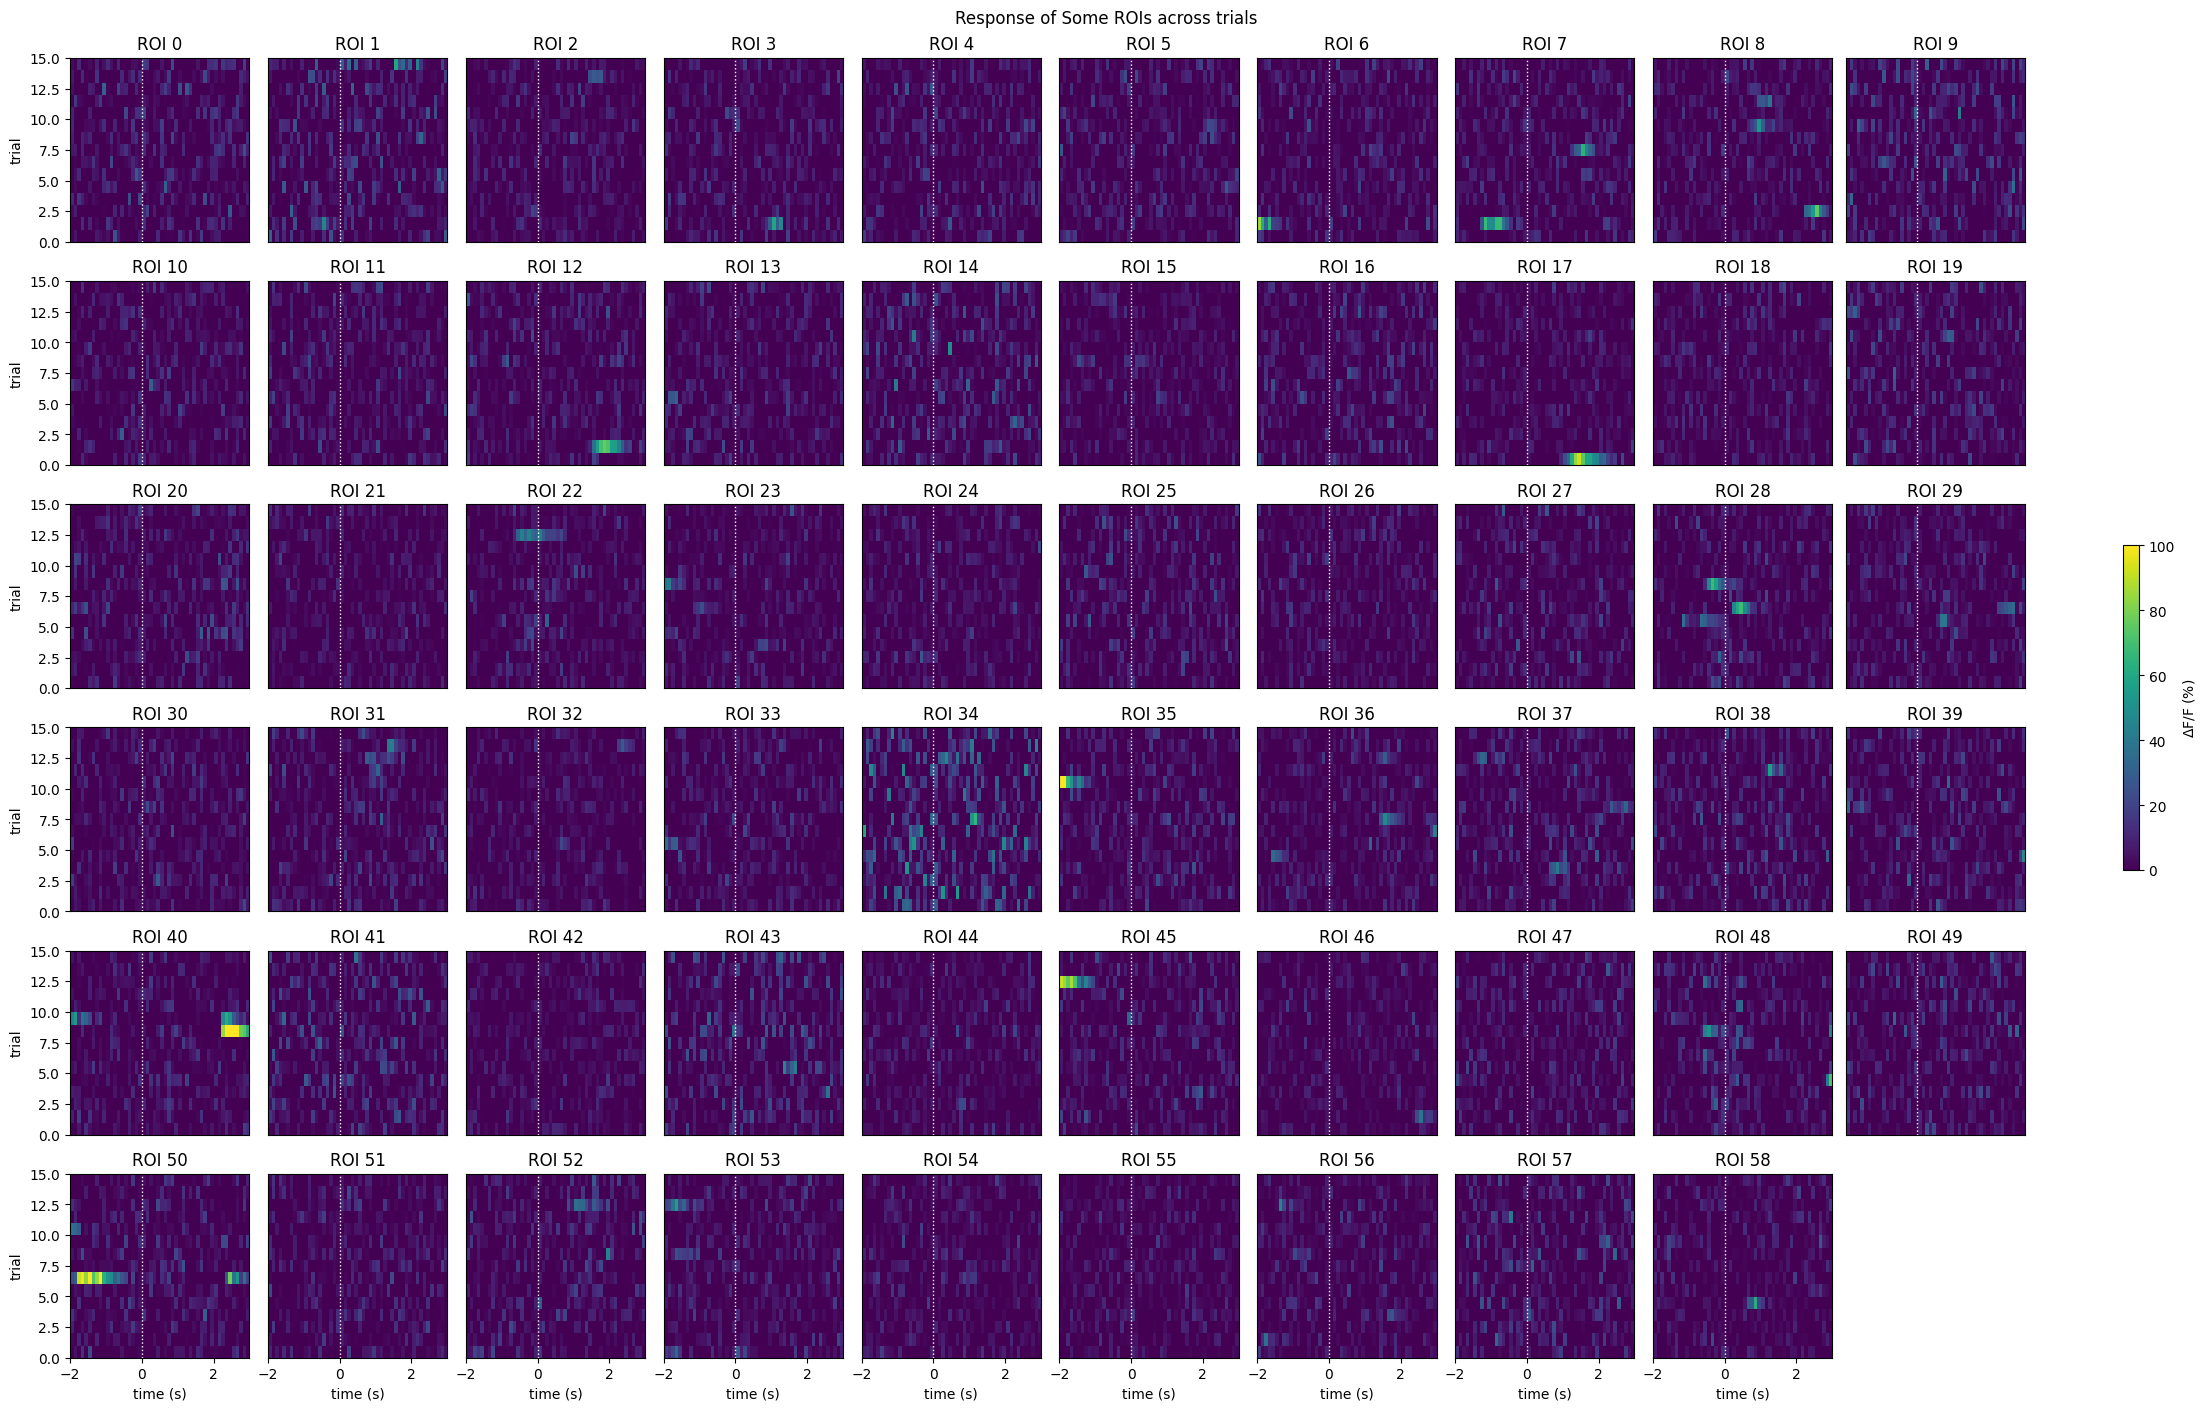

In [31]:
show_many_responses(neuronwise_windows,
                    6,
                    10,
                    title="Response of Some ROIs across trials",
                    subplot_title="ROI",
                    xlabel="time (s)",
                    ylabel="trial",
                    cbar_label="$\Delta$F/F (%)")

### Selecting Cells

In [32]:
# get the index within the window that stimulus occurs (time 0)
stimulus_onset_idx = int(-window_start_time * interp_hz)
baseline = windows[:,:,0:stimulus_onset_idx]
evoked_responses = windows[:,:,stimulus_onset_idx:]

print(stimulus_onset_idx)
print(baseline.shape)
print(evoked_responses.shape)

20
(15, 59, 20)
(15, 59, 30)


In [33]:
mean_trial_responses = np.mean(evoked_responses, axis=2)
mean_trial_baselines = np.mean(baseline, axis=2)

n = mean_trial_responses.shape[0]
t,p = ttest_ind(mean_trial_responses, mean_trial_baselines)
IC3_selected_rois = np.where(p < 0.05 / n)[0]
print(f"Selected ROIs {IC3_selected_rois}")

Selected ROIs []
